# Advance Machine Learning for Natural Language Processing and Text Processing 
## Project 2 : Insurance reviews

This dataset contains reviews published by insurance customers. There are different columns : 
- date: it contains the date of the publication of the review and the period of the review
experience, and it has to be cleaned.
- note: it is the number of stars given by the customer (it should be predicted in the test
dataset)
- auteur: the id of the customer
- avis: the review
- assureur: the name of the insurance
- produit: the type of insurance

### Data import and pre-processing

In [1]:
!pip install pandas numpy plotly sklearn stop_words nltk wordcloud 

In [2]:
import pandas as pd
import numpy as np
import plotly.express as plt
import plotly.graph_objects as go
import matplotlib.pyplot as pyplot

from wordcloud import WordCloud, STOPWORDS

from stop_words import get_stop_words
import nltk
from nltk.tokenize import TreebankWordTokenizer, word_tokenize
from nltk.stem.snowball import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

from sklearn.cluster import KMeans

In [3]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cheic\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cheic\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
pd.set_option('display.max_rows', 500)

In [5]:
dataset = pd.read_csv('./dataset/avisassurance_train.csv', sep=";")
dataset.head(10)

,date,note,auteur,avis,assureur,produit
0,06 septem...,5,brahim--k-131532,"Meilleurs assurances, prix, solutions, écoute,...",Direct Assurance,auto
1,03 mai 20...,4,bernard-g-112497,"je suis globalement satisfait , sauf que vous ...",Direct Assurance,auto
2,21 mars 2...,5,virginie-t-107352,Prix tres abordable plusieurs options s'offren...,Direct Assurance,auto
3,10 juin 2...,4,boulain-f-116580,"je satisfait du service, une réponse très rapi...",L'olivier Assurance,auto
4,29 janvie...,1,ouaille31-51798,"Client depuis plus de 25 ans, très déçu de cet...",Matmut,auto
5,06 mars 2...,1,spam-62064,"Vente forcée par téléphone, prétextant des évè...",Néoliane Santé,sante
6,05 octobr...,3,ludovic-b-135966,Nouveau client satisfait du prix et des servic...,APRIL,sante
7,17 septem...,1,laetitia741-97523,Un assureur m'a contacté par telephone pour me...,SantéVet,animaux
8,12 janvie...,1,gbernard10-102485,Je ne peux que rejoindre les nombreux avis nég...,Mercer,sante
9,21 mars 2...,1,rezo31-62544,GENERALI ASSURANCES VIE PATRIMOINE Très mauvai...,Generali,vie


In [6]:
def date_format(value): 
    day, month, year = value.lower().strip().split(' ')[:3]

    if month == 'janvier': 
        month = '01'
    elif month == 'février' or month == 'fevrier': 
        month = '02'
    elif month == 'mars': 
        month = '03'
    elif month == 'avril': 
        month = '04'
    elif month == 'mai': 
        month = '05'
    elif month == 'juin': 
        month = '06'
    elif month == 'juillet': 
        month = '07'
    elif month == 'aout' or 'août': 
        month = '08'
    elif month == 'septembre': 
        month = '09'
    elif month == 'octobre': 
        month = '10'
    elif month == 'novembre': 
        month = '11'
    elif month == 'decembre' or 'décembre': 
        month = '12'
        
    return pd.to_datetime(year + "-" + month + "-" + day)

In [7]:
df = dataset.copy()

#### Handle NaN values

In [8]:
df.isna().sum()

date        0
note        0
auteur      1
avis        1
assureur    0
produit     0
dtype: int64

In [9]:
# We decide to keep that row and just put an empty string where the value is missing for 'avis'
df['avis'].fillna('', inplace=True)
df['auteur'].fillna('', inplace=True)

#### Parse date

In [10]:
df['date'] = df.date.apply(date_format)

####  Pre-processing avis

In [11]:
stop_words = get_stop_words('french')
stop_words.extend(['je', 'tu', 'il', 'elle', 'on', 'nous', 'vous', 'ils', 'elles', 
                   'mon', 'ma', 'ton', 'ta', 'mes', 'tes', 'chez', "ca", "c'est", 
                   "des", "les", 'cordialement', 'bonjour', 'merci', 'sa', 'son', 'ses', 
                   "qu", "un", "une", "donc", "bref", "dont", "j'ai", "plu", "contrat", "contrats", 
                   "assurance", "assurances", "assureur", 'à', 'etc'])

In [12]:
tokenizer = TreebankWordTokenizer()
stemmer = SnowballStemmer("french", ignore_stopwords=True)

In [13]:
def process_avis(avis): 
    # Lower avis
    avis = avis.lower()
    # Tokenize
    avis = word_tokenize(avis)
    # Remove stop words
    avis = [i for i in avis if i not in stop_words]
    # Remove empty strings
    avis = [i for i in avis if i]
    # Remove punctation marks
    avis = [i for i in avis if i not in list(',.;:!?()-"`+')]
    return avis

In [14]:
df['processed_avis'] = df['avis'].apply(process_avis)

### Data visualisation

In [29]:
# Note moyenne par assureur
mean_by_insurance = df.groupby('assureur')['note'].mean().sort_values(ascending=False)
fig = plt.bar(mean_by_insurance, title="Note moyenne par assureur")
fig.show()

In [30]:
# Note moyenne par produit
mean_by_product = df.groupby('produit')['note'].mean().sort_values(ascending=False)
fig = plt.bar(mean_by_product, title="Note moyenne par produit")
fig.show()

In [18]:
assureurs = list(set(df.assureur))
assureurs.sort()

In [19]:
# Create a DF for each insurance company in order to visualize the 'note'
df_by_insurances = [x for _, x in df.groupby(df['assureur'])]

In [20]:
fig = go.Figure()
buttons = [{
    "label": "Choisir l'assureur: ", 
    "method": "update", 
    "args": [{'visible': [False for assureur in assureurs]}]}]

for insurance in range(len(assureurs)): 
    trace = go.Bar(
        y = df_by_insurances[insurance].groupby('note')['note'].count().index, 
        x = df_by_insurances[insurance].groupby('note')['note'].count(), 
        orientation ='h', 
        name = assureurs[insurance]
    )
    btnx = {
        "label": assureurs[insurance], 
        'method': 'update',
        "args": [{'visible': [True if insurance == assureurs.index(assurance) else False for assurance in assureurs]}]}
    
    fig.add_trace(trace)
    buttons.append(btnx)
    
     
fig.update_layout(
    {"updatemenus":[
        go.layout.Updatemenu(
            buttons=buttons, 
            direction="down", 
            showactive=True,
            xanchor="left", x=0, yanchor="top", y=1.1
        )],
        'title_text': 'Nombre de notes données par assureur',
        'xaxis': dict(title="Nombre d'avis", tickangle=45),
        'yaxis_title_text': 'Note',
        "width": 800, "height": 600,
        "autosize": True
    }
)

In [51]:
fig = go.Figure()
buttons = [{
    "label": "Choisir l'assureur: ", 
    "method": "update", 
    "args": [{'visible': [False for assureur in assureurs]}]}]

for insurance in range(len(assureurs)): 
    trace = go.Scatter(
        x = df.groupby(df_by_insurances[insurance].date.dt.year)['note'].mean().index, 
        y = df.groupby(df_by_insurances[insurance].date.dt.year)['note'].mean(), 
        name = assureurs[insurance]
    )
    btnx = {
        "label": assureurs[insurance], 
        'method': 'update',
        "args": [{'visible': [True if insurance == assureurs.index(assurance) else False for assurance in assureurs]}]}
    
    fig.add_trace(trace)
    buttons.append(btnx)
    
     
fig.update_layout(
    {"updatemenus":[
        go.layout.Updatemenu(
            buttons=buttons, 
            direction="down", 
            showactive=True,
            xanchor="left", x=0, yanchor="top", y=1.1
        )],
        'title_text': 'Evolution de la note moyenne annuelle par assureur',
        'xaxis': dict(title="Date", tickangle=45),
        'yaxis_title_text': 'Note',
        "width": 800, "height": 600,
        "autosize": True
    }
)

#### Word clouds

In [21]:
def wordcloud_for_star(star = 1): 
    wordcloud = df[df['note'] == star].processed_avis.tolist()
    wordcloud = [item for sublist in wordcloud for item in sublist]
    wordcloud = ' '.join(wordcloud)
    return wordcloud

In [22]:
wordcloud_1 = WordCloud(background_color='white', stopwords=stop_words, min_font_size=10).generate(wordcloud_for_star(star = 1))
wordcloud_2 = WordCloud(background_color='white', stopwords=stop_words, min_font_size=10).generate(wordcloud_for_star(star = 2))
wordcloud_3 = WordCloud(background_color='white', stopwords=stop_words, min_font_size=10).generate(wordcloud_for_star(star = 3))
wordcloud_4 = WordCloud(background_color='white', stopwords=stop_words, min_font_size=10).generate(wordcloud_for_star(star = 4))
wordcloud_5 = WordCloud(background_color='white', stopwords=stop_words, min_font_size=10).generate(wordcloud_for_star(star = 5))

##### Reviews for 1 star

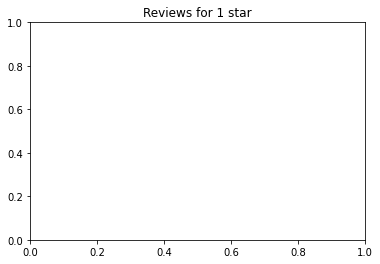

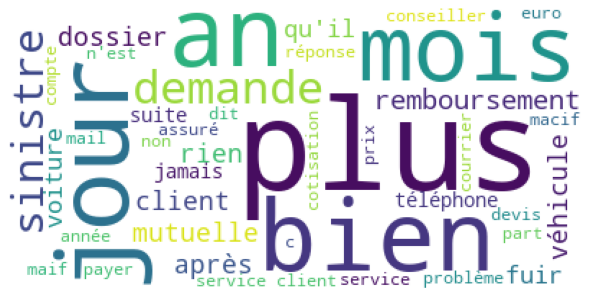

In [28]:
# plot the WordCloud image  
pyplot.figure(figsize = (8, 8), facecolor = None)
pyplot.imshow(wordcloud_1)
pyplot.axis("off")
pyplot.tight_layout(pad = 0)
 
pyplot.show()

##### Reviews for 2 stars

In [ ]:
plot the WordCloud image  
pyplot.figure(figsize = (8, 8), facecolor = None)
pyplot.imshow(wordcloud_2)
pyplot.axis("off")
pyplot.tight_layout(pad = 0)
 
pyplot.show()

##### Reviews for 3 stars

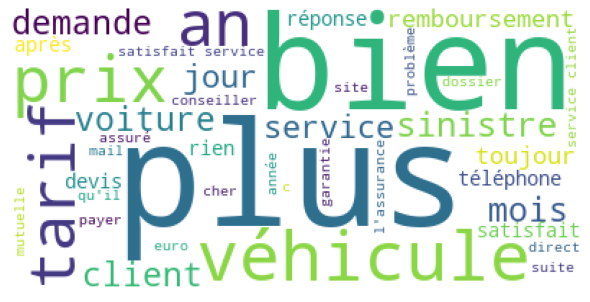

In [25]:
# plot the WordCloud image  
pyplot.figure(figsize = (8, 8), facecolor = None)
pyplot.imshow(wordcloud_3)
pyplot.axis("off")
pyplot.tight_layout(pad = 0)
 
pyplot.show()

##### Reviews for 4 stars

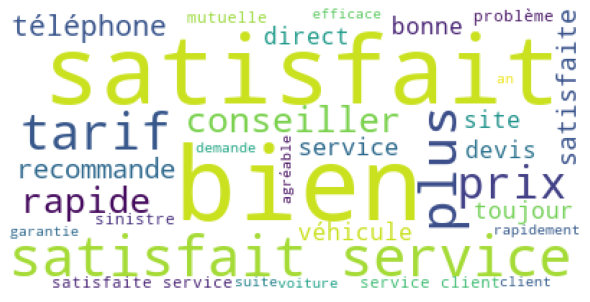

In [26]:
# plot the WordCloud image  
pyplot.figure(figsize = (8, 8), facecolor = None)
pyplot.imshow(wordcloud_4)
pyplot.axis("off")
pyplot.tight_layout(pad = 0)
 
pyplot.show()

##### Reviews for 5 stars

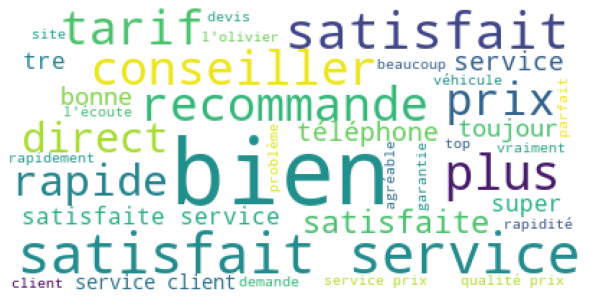

In [27]:
# plot the WordCloud image  
pyplot.figure(figsize = (8, 8), facecolor = None)
pyplot.imshow(wordcloud_5)
pyplot.axis("off")
pyplot.tight_layout(pad = 0)
 
pyplot.show()

### Supervised Learning - Classification

####  Split train and test dataset

In [52]:
X_train, X_test, y_train, y_test = train_test_split(df.avis, df.note, test_size = 0.20)

In [61]:
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

#### Naive Bayes

In [53]:
text_clf = Pipeline([
    ('vect', CountVectorizer(stop_words=stop_words)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

text_clf.fit(X_train, y_train)

print(f"Accuracy on train : {text_clf.score(X_train, y_train)}")
print(f"Accuracy on test : {np.mean(text_clf.predict(X_test) == y_test)}")

Accuracy on train : 0.5901265297656088
Accuracy on test : 0.5044596556730969


In [62]:
stemmed_count_vect = StemmedCountVectorizer(stop_words=stop_words)
text_mnb_stemmed = Pipeline([
    ('vect', stemmed_count_vect),
    ('tfidf', TfidfTransformer()),
    ('mnb', MultinomialNB(fit_prior=False)),
])
text_mnb_stemmed = text_mnb_stemmed.fit(X_train, y_train)
print(np.mean(text_mnb_stemmed.predict(X_test) == y_test))

0.5191868906865795


#### Grid Search

In [54]:
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'clf__alpha': (1e-2, 1e-3),
}

In [58]:
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(X_train, y_train)

print(gs_clf.best_score_)
print(gs_clf.best_params_)

print(f"Accuracy on train : {gs_clf.score(X_train, y_train)}")
print(f"Accuracy on test : {np.mean(gs_clf.predict(X_test) == y_test)}")

np.mean(gs_clf.predict(X_test) == y_test)

0.5078303902910803
{'clf__alpha': 0.01, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 1)}
Accuracy on train : 0.7771209292677868
Accuracy on test : 0.5011408421489317


0.5011408421489317

#### SVM

In [59]:
text_clf_svm = Pipeline([
    ('vect', CountVectorizer(stop_words=stop_words)),
    ('tfidf', TfidfTransformer()),
    ('clf-svm', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42))
])

_ = text_clf_svm.fit(X_train, y_train)

np.mean(text_clf_svm.predict(X_test) == y_test)

0.4994814353868492

In [60]:
parameters_svm = {'vect__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'clf-svm__alpha': (1e-2, 1e-3),
}

gs_clf_svm = GridSearchCV(text_clf_svm, parameters_svm, n_jobs=-1)
gs_clf_svm = gs_clf_svm.fit(X_train, y_train)

print(gs_clf_svm.best_score_)
print(gs_clf_svm.best_params_)
print(np.mean(gs_clf_svm.predict(X_test) == y_test))

0.505807770427643
{'clf-svm__alpha': 0.01, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}
0.5061190624351795


#### RandomForest Classifier

In [63]:
text_rfc_stemmed = Pipeline([
    ('vect', stemmed_count_vect),
    ('tfidf', TfidfTransformer()),
    ('rfc', RandomForestClassifier(n_estimators=400, max_depth=80)),
])

text_rfc_stemmed.fit(X_train, y_train)
text_rfc_stemmed.score(X_test, y_test)

0.5086081725783033

### Supervised Learning - Regression

#### Linear regression

In [68]:
text_linreg_stemmed = Pipeline([
    ('vect', stemmed_count_vect),
    ('tfidf', TfidfTransformer()),
    ('linreg', LinearRegression()),
])

text_linreg_stemmed = text_linreg_stemmed.fit(X_train, y_train)
print("Score: ", text_linreg_stemmed.score(X_test, y_test))
print("RMSE: ", mean_squared_error(y_test, text_linreg_stemmed.predict(X_test), squared=True))

Score: -1.0320794398702957
RMSE: 4.720807204464285


#### RandomForest Regressor

In [70]:
text_rfr_stemmed = Pipeline([('vect', stemmed_count_vect),
                     ('tfidf', TfidfTransformer()),
                     ('rfr', RandomForestRegressor()),
])
text_rfr_stemmed = text_rfr_stemmed.fit(X_train, y_train)

print("Score : ", text_rfr_stemmed.score(X_test, y_test))
print("RMSE: ", mean_squared_error(y_test, text_rfr_stemmed.predict(X_test), squared=True))

Score :  0.6095795814514491
RMSE:  0.9070017089349631


#### GridSearch on RandomForest

In [ ]:
param_grid = {
    'rfr__bootstrap': [False],
    'rfr__max_depth': [5, 10, 15, 25],
    'rfr__max_features': ['sqrt'],
    'rfr__min_samples_leaf': [1],
    'rfr__min_samples_split': [4],
    'rfr__n_estimators': [550, 600, 650]
}

grid_search = GridSearchCV(estimator = text_rfr_stemmed, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)
grid_search.fit(X_train, y_train)

print("Best RandomForestRegressor : ", grid_search.best_estimator_)
print("\nBest RandomForestRegressor score : ", grid_search.best_score_)
print("\nBest parameters : ", grid_search.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


#### Gradient Boosting Regressor

In [ ]:
text_gbr_stemmed = Pipeline([('vect', stemmed_count_vect),
                     ('tfidf', TfidfTransformer()),
                     ('gbr', GradientBoostingRegressor()),
])
text_gbr_stemmed = text_gbr_stemmed.fit(X_train, y_train)

print("Score : ", text_gbr_stemmed.score(X_test, y_test))
print("RMSE : ", mean_squared_error(y_test, text_gbr_stemmed.predict(X_test), squared=True))

In [ ]:
param_grid = {
    'gbr__max_depth': [10],
    'gbr__min_samples_split': [0.1],
    'gbr__min_samples_leaf': [1],
    'gbr__learning_rate': [0.1, 0.05, 0.01]
}
grid_search = GridSearchCV(estimator = text_gbr_stemmed, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)
grid_search.fit(X_train, y_train)

print("Best GradientBoostingRegressor : ", grid_search.best_estimator_)
print("\nBest GradientBoostingRegressor score : ", grid_search.best_score_)
print("\nBest parameters : ", grid_search.best_params_)